In [ ]:
#!python -m nltk.downloader all

In [129]:
import pandas as pd
import numpy as np
import nltk 
import re
#nltk.download()
file = 'data/EscortDataLabelAll.csv'
df = pd.read_csv(file)
data = df[['tweet','SUSPICIOUS']].copy()
data

,tweet,SUSPICIOUS
0,rt @_just__v: available for romantic appointme...,1
1,requiring a #mature dinner companion in #orlan...,1
2,wanting to plan a sensual escape in #orlando? ...,1
3,"Ã°ÂŸÂ“Â£well, now am i not only open for inqui...",1
4,#orlando #florida &amp; surrounding cities. \n...,0
...,...,...
2216,"#mellabellaexperience \nhouston, tx book me \n...",1
2217,had such an amazing time today for my photosho...,1
2218,astros won !!! Ã¢ÂšÂ¾Ã¯Â¸ÂÃ°ÂŸÂ¤Â˜Ã°ÂŸÂÂ¾ #h...,0
2219,#cameroon soldiers are said to have raided a v...,0


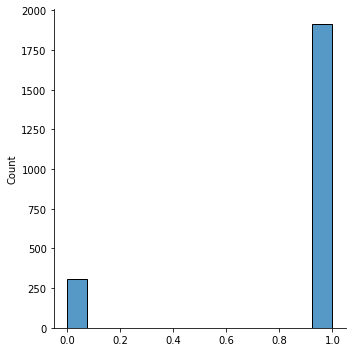

In [130]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.displot(list(df['SUSPICIOUS']))

In [131]:
from nltk import word_tokenize
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from nltk.stem import WordNetLemmatizer
import sklearn
stop_words = stopwords.words('english')
def clean_text(df):
    df['clean_text'] = df['tweet'].apply(lambda elem: re.sub(r"(@[A-Za-z0-9]+)|([^0-9A-Za-z \t])|(\w+:\/\/\S+)|^rt|http.+?", "", elem))
    return df
def tokenize(row):
    res = word_tokenize(row['clean_text'])
    return res
def stop_word_filtering(row):
    res = [word for word in row['token'] if word not in stop_words]
    return res
def lemmatizer(row):   
    res = [WordNetLemmatizer().lemmatize(word=word) for word in row['token'] ]
    return res
def rejoin(row):
    res = ''
    for i in row['lement']:
        res+=i
        res+=' '
    return res
data = clean_text(data)
data['token']=data.apply(tokenize,axis=1)
data['token']=data.apply(stop_word_filtering,axis=1)
data['lement']=data.apply(lemmatizer,axis=1)
data['final'] = data.apply(rejoin,axis=1)
vectorizer= sklearn.feature_extraction.text.TfidfVectorizer().fit(data['final'])
X = vectorizer.transform(data['final'])
data['tfidf']=X.toarray().tolist()
y = list(data['SUSPICIOUS'])

In [132]:
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split, GridSearchCV
svc = SVC()
param_grid = {'C': [0.1, 1, 10, 100, 1000],
              'gamma': [1, 0.1, 0.01, 0.001, 0.0001],
              'kernel': ['rbf','linear','poly','sigmoid']}

In [133]:
X_train, X_test,y_train, y_test = train_test_split(X,y,test_size=.2, random_state=42)
grid = GridSearchCV(svc,param_grid,refit=True)
grid.fit(X_train,y_train)

GridSearchCV(estimator=SVC(),
             param_grid={'C': [0.1, 1, 10, 100, 1000],
                         'gamma': [1, 0.1, 0.01, 0.001, 0.0001],
                         'kernel': ['rbf', 'linear', 'poly', 'sigmoid']})

In [134]:
print(grid.best_params_)
print(grid.best_estimator_)

{'C': 10, 'gamma': 1, 'kernel': 'linear'}
SVC(C=10, gamma=1, kernel='linear')


In [135]:
grid_pred = grid.predict(X_test)
print(classification_report(y_test,grid_pred))

              precision    recall  f1-score   support

           0       0.98      0.73      0.84        64
           1       0.96      1.00      0.98       381

    accuracy                           0.96       445
   macro avg       0.97      0.87      0.91       445
weighted avg       0.96      0.96      0.96       445



In [136]:
import joblib
joblib.dump(grid,'models/model.pkl')
joblib.dump(vectorizer,'models/vectorizer.pkl')

['models/vectorizer.pkl']

In [116]:
class pipeline:
    def __init__(self,df):
        self.df = df
        self.process()
    def clean_text(self,df):
        df['clean_text'] = df['tweet'].apply(lambda elem: re.sub(r"(@[A-Za-z0-9]+)|([^0-9A-Za-z \t])|(\w+:\/\/\S+)|^rt|http.+?", "", elem))
        return df
    def tokenize(self,row):
        res = word_tokenize(row['clean_text'])
        return res
    def stop_word_filtering(self,row):
        res = [word for word in row['token'] if word not in stop_words]
        return res
    def lemmatizer(self,row):   
        res = [WordNetLemmatizer().lemmatize(word=word) for word in row['token'] ]
        return res
    def rejoin(self,row):
        res = ''
        for i in row['lement']:
            res+=i
            res+=' '
        return res
    def process(self):
        self.df = clean_text(self.df)
        self.df['clean_text'] = self.df['clean_text'].str.lower()
        self.df['token']=self.df.apply(tokenize,axis=1)
        self.df['token']=self.df.apply(stop_word_filtering,axis=1)
        self.df['lement']=self.df.apply(lemmatizer,axis=1)
        self.df['final'] = self.df.apply(rejoin,axis=1)
    def returnDf(self):
        return self.df
    def returnX(self,vectorizer):
        
        self.X = vectorizer.transform(self.df['final'])
        return self.X


In [120]:
final_df = pd.read_csv('data/cleanData.csv')
final_df = final_df['clean_text'].to_frame()
final_df.rename(columns={'clean_text':'tweet'},inplace=True)
pipe = pipeline(final_df)
final_X = pipe.returnX(data['final'])
final_df = pipe.returnDf()

In [121]:
final_params = {'C': 10, 'gamma': 1, 'kernel': 'linear'}
final_pred = grid.predict(final_X)

In [122]:
final_df['suspicion'] = final_pred

In [125]:
final_df[['tweet','suspicion']]

,tweet,suspicion
0,To a GREAT Friend amp Kind Heart here are ALL ...,1
1,remember when Syracuse was a football blue blo...,0
2,Syracuse orange autograph floyd little jersey ...,1
3,RT Legends GOAT SYRACUSE Csonka Little Coughl...,1
4,RT Legends GOAT SYRACUSE Csonka Little Coughl...,1
...,...,...
4403,RT Hey Baking friendsWHY FORK LINES IN PEANU...,1
4404,RT Hey Baking friendsWHY FORK LINES IN PEANU...,1
4405,Hey Baking friendsWHY FORK LINES IN PEANUTBUT...,1
4406,Rawr Check out these adorable costumes Hallowe...,0
